In [34]:
# 중심축 기반 부피 계산
import trimesh
import numpy as np
from scipy.spatial.transform import Rotation
from scipy.optimize import least_squares

# 상수 정의
THICKNESS = 0.0003 ##단면의 두께
MIN_POINTS_PER_SLICE = 10 ##원 검출 시 최소 포인트 수
MAX_CONSECUTIVE_FAILURES = 3 ##원 검출 시 최대 연속 실패 횟수
MIN_RADIUS, MAX_RADIUS = 0.02, 0.1 ##원 검출 시 최소 및 최대 반지름
MIN_POINTS_PER_METER = 50.0 ##중심축 기반 원검출시 

# GLB 로드 및 z축이 중력방향이 되도록 scene을 회전하는 함수
def load_and_align_scene(filepath):
    scene = trimesh.load(filepath)
    A = np.array(scene.metadata.get('hf_alignment', np.eye(4))).reshape(4, 4)
    gravity = (A[:3, :3] @ np.array([[1,0,0],[0,-1,0],[0,0,-1]]) @ np.array([0,1,0]))
    gravity = gravity / np.linalg.norm(gravity)
    
    R = Rotation.align_vectors([[0, 0, 1]], [gravity])[0]
    T = np.eye(4)
    T[:3, :3] = R.as_matrix()
    for geom in scene.geometry.values():
        geom.apply_transform(T)
    
    for geometry in scene.geometry.values():
        if isinstance(geometry, trimesh.PointCloud):
            return geometry.vertices
    return None


# 원 검출 함수들


# 인라이너 포인트들을 받아서 원의 중심과 반지름을 정확하게 추정하는 함수
def refine_circle_ls(inlier_points):
    if len(inlier_points) < 3:
        return None
    center_init = inlier_points.mean(axis=0)
    radius_init = np.mean(np.linalg.norm(inlier_points - center_init, axis=1))
    
    def residuals(params):
        cx, cy, r = params
        return np.linalg.norm(inlier_points - [cx, cy], axis=1) - r
    
    try:
        result = least_squares(residuals, [center_init[0], center_init[1], radius_init],
                              bounds=([-0.5, -0.5, 0.001], [0.5, 0.5, 0.2]))
        cx, cy, r = result.x
        if 0.01 < r < 0.15:
            return {'center': np.array([cx, cy]), 'radius': r}
    except:
        pass
    return None

# 랜덤 샘플링을 통해 원을 추정하는 함수.한 단면에서 최적의 원을 찾을 때는 단순히 가장 원다운 원(인라이너 비율)을 찾음.
# 여러 단면에서 나온 원들 중에에 중심축을 추정하기 위한 단면을 고를때는 원점과 원중심까지의 거리를 고려해서 상위 5개의 단면의 원들의 중앙값 사용용
def fit_circle_ransac(points_2d, n_iter=50, threshold=0.002, min_inliers=10):
    if len(points_2d) < 3:
        return None
    
    best_circle, best_score = None, 0
    for _ in range(n_iter):
        p1, p2, p3 = points_2d[np.random.choice(len(points_2d), 3, replace=False)]
        try:
            A = np.array([[2*(p2[0]-p1[0]), 2*(p2[1]-p1[1])],
                         [2*(p3[0]-p1[0]), 2*(p3[1]-p1[1])]])
            b = np.array([p2[0]**2 - p1[0]**2 + p2[1]**2 - p1[1]**2,
                         p3[0]**2 - p1[0]**2 + p3[1]**2 - p1[1]**2])
            center = np.linalg.solve(A, b)
            radius = np.linalg.norm(p1 - center)
            
            if not (0.01 < radius < 0.15):
                continue
            
            distances = np.abs(np.linalg.norm(points_2d - center, axis=1) - radius)
            inliers = distances < threshold
            n_inliers = np.sum(inliers)
            
            if n_inliers < min_inliers:
                continue
            
            score = n_inliers / len(points_2d)
            if score > best_score:
                best_score = score
                refined = refine_circle_ls(points_2d[inliers])
                if refined:
                    best_circle = {**refined, 'score': score, 'n_inliers': n_inliers}
        except np.linalg.LinAlgError:
            continue
    return best_circle

## 중심축 기반으로 원 검출 함수. 원의 둘레당 포인트 수를 기반으로 원을 판별 및 면적 계산.
def detect_circle_at_axis(slice_2d, center_axis, n_iter=100, threshold=0.0003):
    if len(slice_2d) < MIN_POINTS_PER_SLICE:
        return None
    
    distances = np.linalg.norm(slice_2d - center_axis, axis=1)
    best_radius, best_ppm = None, 0.0
    
    for _ in range(n_iter):
        r_candidate = distances[np.random.randint(len(slice_2d))]
        if not (MIN_RADIUS <= r_candidate <= MAX_RADIUS):
            continue
        
        inlier_count = np.sum(np.abs(distances - r_candidate) < threshold)
        circumference = 2 * np.pi * r_candidate
        ppm = inlier_count / circumference if circumference > 0 else 0
        
        if ppm > best_ppm:
            best_ppm, best_radius = ppm, r_candidate
    
    if best_radius and best_ppm >= MIN_POINTS_PER_METER:
        return best_radius
    return None

# 유틸리티 함수들
def get_slice(points, z, thickness=THICKNESS):
    """높이 z에서 슬라이스 추출"""
    mask = (points[:, 2] >= z - thickness) & (points[:, 2] <= z + thickness)
    return points[mask]

def add_volume_data(volume_data, z, radius):
    """volume_data에 단면 정보 추가"""
    volume_data.append({'z': z, 'radius': radius, 'area': np.pi * radius**2})

def search_heights(points, z_range, center_axis, volume_data, max_failures=MAX_CONSECUTIVE_FAILURES):
    """높이 범위를 탐색하며 원 검출"""
    failures = 0
    for z in z_range:
        slice_points = get_slice(points, z)
        if len(slice_points) < MIN_POINTS_PER_SLICE:
            failures += 1
            if failures >= max_failures:
                break
            continue
        
        radius = detect_circle_at_axis(slice_points[:, :2], center_axis)
        if radius is not None:
            failures = 0
            add_volume_data(volume_data, z, radius)
        else:
            failures += 1
            if failures >= max_failures:
                break



# 메인 로직
points = load_and_align_scene('/data/ephemeral/home/project/output/scene.glb')

# 전처리: 원점 근처 필터링 및 정렬
mask = np.linalg.norm(points[:, :2], axis=1) < 0.2 #원점기준 xy거리 0.2m 이하 필터링
filtered = points[mask]
sorted_idx = np.argsort(filtered[:, 2])
sorted_points, sorted_heights = filtered[sorted_idx], filtered[sorted_idx, 2]

# 1단계: 중심축 계산
z_range = np.linspace(sorted_heights.min(), sorted_heights.max(), 20) #z축 범위 20개 구간으로 나누기.
circle_data = []
origin = np.array([0, 0])

for z in z_range:
    start = np.searchsorted(sorted_heights, z - THICKNESS)
    end = np.searchsorted(sorted_heights, z + THICKNESS)
    if end - start < MIN_POINTS_PER_SLICE:
        continue
    
    slice_2d = sorted_points[start:end, :2]
    # 원점 거리 페널티 없이 순수하게 원 검출
    circle = fit_circle_ransac(slice_2d, n_iter=30, threshold=0.005, min_inliers=10)
    
    if circle:
        # 원점 거리 계산 및 final_score 계산
        dist_from_origin = np.linalg.norm(circle['center'] - origin)
        final_score = circle['score'] - dist_from_origin * 1.5
        
        circle_data.append({
            'z': z,
            'center': circle['center'],
            'radius': circle['radius'],
            'score': circle['score'],
            'final_score': final_score,
            'dist_from_origin': dist_from_origin
        })

if not circle_data:
    print("컵 원을 찾지 못했습니다.")
else:
    # final_score 기준으로 정렬하여 상위 5개 선택
    circle_data.sort(key=lambda x: x['final_score'], reverse=True)
    top_5_circles = circle_data[:5]
    center_axis = np.median([c['center'] for c in top_5_circles], axis=0) ##중심축
    reference_z = top_5_circles[0]['z'] ##부피 계산 할때 처음 탐색을 시작할 z값. final score가장 높은 단면
    
    print(f"중심축: ({center_axis[0]:.6f}, {center_axis[1]:.6f}), 기준 높이: {reference_z:.4f}m")
    
    # 2단계: 부피 계산을 위한 원 검출
    volume_data = []
    z_min, z_max = points[:, 2].min(), points[:, 2].max()
    STEP = 0.002  # 2mm 간격
    
    # 기준 높이에서 원 검출 시도
    ref_slice = get_slice(points, reference_z)
    if len(ref_slice) >= MIN_POINTS_PER_SLICE:
        ref_radius = detect_circle_at_axis(ref_slice[:, :2], center_axis)
        if ref_radius:
            add_volume_data(volume_data, reference_z, ref_radius)
    
    # 위쪽 탐색: 기준 높이 + 0.002, + 0.004, ... (z_max까지)
    z_above = np.arange(reference_z + STEP, z_max + STEP, STEP)
    search_heights(points, z_above, center_axis, volume_data)
    
    # 아래쪽 탐색: 기준 높이 - 0.002, - 0.004, ... (z_min까지)
    z_below = np.arange(reference_z - STEP, z_min - STEP, -STEP)
    search_heights(points, z_below, center_axis, volume_data)
    
    # 3단계: 부피 계산
    if volume_data:
        volume_data.sort(key=lambda x: x['z'])
        total_volume = sum((volume_data[i]['area'] + volume_data[i+1]['area']) / 2 * 
                          (volume_data[i+1]['z'] - volume_data[i]['z']) 
                          for i in range(len(volume_data) - 1))
        
        print(f"\n단면 개수: {len(volume_data)}개")
        print(f"높이: {volume_data[0]['z']:.4f}m ~ {volume_data[-1]['z']:.4f}m")
        print(f"부피: {total_volume * 1000:.2f} mL ({total_volume * 1e6:.2f} cm³)")
    else:
        print("원을 찾지 못했습니다.")

중심축: (0.050552, 0.035250), 기준 높이: 0.0651m

단면 개수: 84개
높이: -0.0529m ~ 0.1131m
부피: 1.23 mL (1227.09 cm³)


In [32]:
# Visualization function

def visualize_detect_circle_at_axis(points, z, center_axis, threshold=0.0003):
    """Visualize detect_circle_at_axis result for a given height"""
    # Extract slice
    slice_points = get_slice(points, z)
    if len(slice_points) < MIN_POINTS_PER_SLICE:
        print(f"Insufficient points at height {z:.4f}m ({len(slice_points)} points)")
        return
    
    slice_2d = slice_points[:, :2]
    
    # Detect circle
    radius = detect_circle_at_axis(slice_2d, center_axis, threshold=threshold)
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    # Calculate distances from center axis
    distances = np.linalg.norm(slice_2d - center_axis, axis=1)
    
    if radius:
        # Separate inliers/outliers
        inliers = np.abs(distances - radius) < threshold
        
        # Inliers (red)
        ax.scatter(slice_2d[inliers, 0], slice_2d[inliers, 1], 
                  c='red', s=20, alpha=0.7, label=f'Inliers ({np.sum(inliers)})')
        
        # Outliers (gray)
        ax.scatter(slice_2d[~inliers, 0], slice_2d[~inliers, 1], 
                  c='lightgray', s=5, alpha=0.3, label='Outliers')
        
        # Draw detected circle
        theta = np.linspace(0, 2*np.pi, 100)
        circle_x = center_axis[0] + radius * np.cos(theta)
        circle_y = center_axis[1] + radius * np.sin(theta)
        ax.plot(circle_x, circle_y, 'b-', linewidth=2, label=f'Circle (r={radius:.4f}m)')
        
        # Calculate point density
        circumference = 2 * np.pi * radius
        ppm = np.sum(inliers) / circumference if circumference > 0 else 0
        
        ax.set_title(f'Height {z:.4f}m - Circle Detected\nRadius: {radius:.4f}m, Density: {ppm:.1f} points/m')
    else:
        # Circle detection failed
        ax.scatter(slice_2d[:, 0], slice_2d[:, 1], c='gray', s=10, alpha=0.5)
        ax.set_title(f'Height {z:.4f}m - Circle Detection Failed')
    
    # Mark center axis
    ax.plot(center_axis[0], center_axis[1], 'go', markersize=10, 
           label=f'Center Axis ({center_axis[0]:.4f}, {center_axis[1]:.4f})')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

def visualize_fit_circle_ransac(points, z, threshold=0.005):
    """Visualize fit_circle_ransac result for a given height"""
    # Extract slice
    slice_points = get_slice(points, z)
    if len(slice_points) < MIN_POINTS_PER_SLICE:
        print(f"Insufficient points at height {z:.4f}m ({len(slice_points)} points)")
        return
    
    slice_2d = slice_points[:, :2]
    
    # Detect circle (center and radius)
    circle = fit_circle_ransac(slice_2d, n_iter=30, threshold=threshold, min_inliers=10)
    
    # Visualization
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    if circle:
        center = circle['center']
        radius = circle['radius']
        score = circle['score']
        n_inliers = circle['n_inliers']
        
        # Separate inliers/outliers
        distances = np.abs(np.linalg.norm(slice_2d - center, axis=1) - radius)
        inliers = distances < threshold
        
        # Inliers (red)
        ax.scatter(slice_2d[inliers, 0], slice_2d[inliers, 1], 
                  c='red', s=20, alpha=0.7, label=f'Inliers ({n_inliers})')
        
        # Outliers (gray)
        ax.scatter(slice_2d[~inliers, 0], slice_2d[~inliers, 1], 
                  c='lightgray', s=5, alpha=0.3, label='Outliers')
        
        # Draw detected circle
        theta = np.linspace(0, 2*np.pi, 100)
        circle_x = center[0] + radius * np.cos(theta)
        circle_y = center[1] + radius * np.sin(theta)
        ax.plot(circle_x, circle_y, 'b-', linewidth=2, label=f'Circle (r={radius:.4f}m)')
        
        # Mark center
        ax.plot(center[0], center[1], 'bo', markersize=10, 
               label=f'Center ({center[0]:.4f}, {center[1]:.4f})')
        
        # Calculate distance from origin
        dist_from_origin = np.linalg.norm(center - np.array([0, 0]))
        
        ax.set_title(f'Height {z:.4f}m - Circle Detected\n'
                    f'Radius: {radius:.4f}m, Score: {score:.3f}, '
                    f'Distance from origin: {dist_from_origin:.4f}m')
    else:
        # Circle detection failed
        ax.scatter(slice_2d[:, 0], slice_2d[:, 1], c='gray', s=10, alpha=0.5)
        ax.set_title(f'Height {z:.4f}m - Circle Detection Failed')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()

# Usage example:
# visualize_fit_circle_ransac(points, 0.05)  # Visualize at height 0.05m

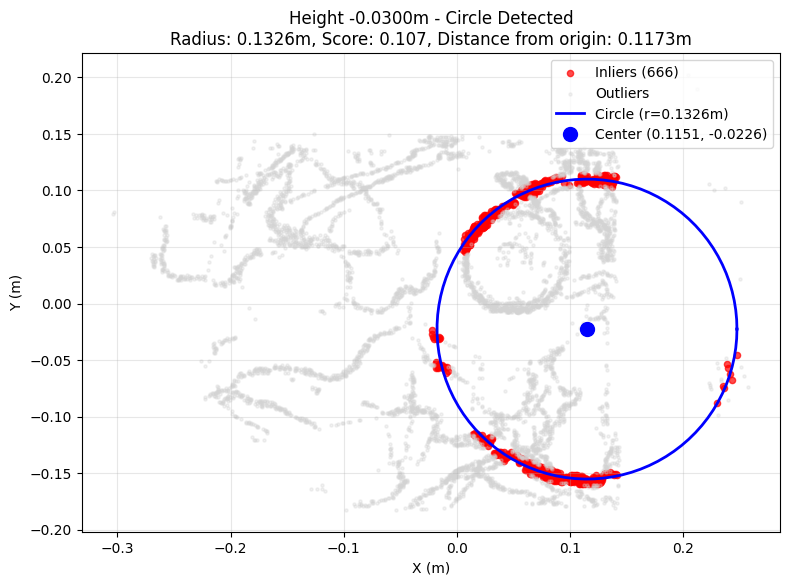

In [33]:
visualize_fit_circle_ransac(points, -0.03)  # Visualize at height 0.05m

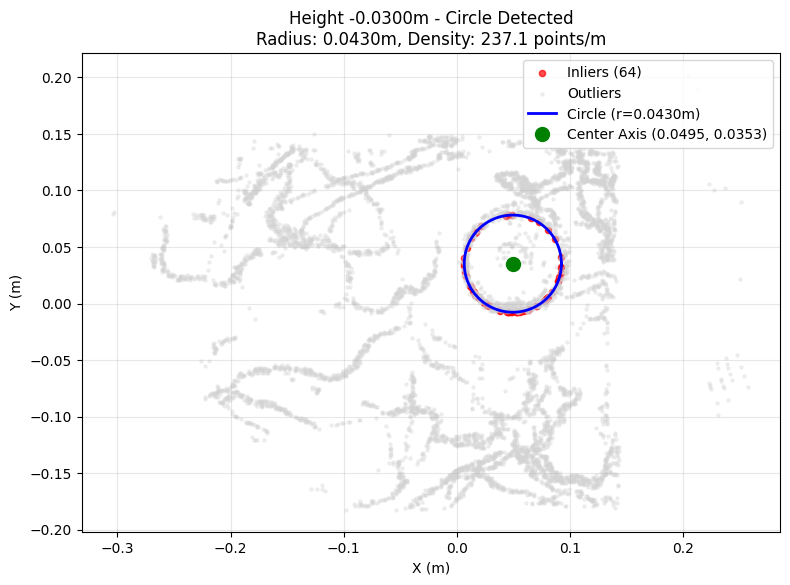

In [30]:
visualize_detect_circle_at_axis(points, -0.03, center_axis)